In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform
import models.SIR as SIR

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [5]:
# Confirmed, Recovered and Death Cases
IRD = transform.IRD(min_confirmed=100, min_recovered=0, min_deaths=0)

In [6]:
min_days = 0
max_days = 60
cases = {}
recoveries = {}
deaths = {}
start_days = np.argmax((IRD[0].values>=30),axis=1)
for i, country in enumerate(IRD[0].index):
    if len(IRD[0].T[country].values[start_days[i]:])>=min_days:
        time_slice = slice(start_days[i], start_days[i]+max_days, 1)
        
        cases[country] = np.array(IRD[0].T[country].values[time_slice]).astype(np.float32)
        recoveries[country] = np.array(IRD[1].T[country].values[time_slice]).astype(np.float32)
        deaths[country] = np.array(IRD[2].T[country].values[time_slice]).astype(np.float32)

In [7]:
pops = transform.population()

Number of unmatched regions : 45
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [8]:
country = 'South Africa'
N_pop = pops.T[country].values[0]
cases = cases[country][:13]
recoveries = recoveries[country][:13]
deaths = deaths[country][:13]

In [18]:
def model():
    
    country = 'South Africa'
    ############  
    # Initial Infection Rate
    Ii = numpyro.sample('Ii', dist.Normal(100.0, 50.0))
    # Initial Removed Rate
    Ri = numpyro.sample('Ri', dist.Normal(1.0, 5.0))
    # Basic reproductive rate
    R0 = numpyro.sample('R0', dist.Normal(2.5, 1.0))
    # Time to removal
    Tr = numpyro.sample('Tr', dist.Normal(20.0, 10.0))
    
#     sigma_I = numpyro.sample('sigma_I',dist.HalfNormal())
    sigma_I = 1.0
    sigma_R = 1.0
    
    N_days = len(cases)
    removed = recoveries + deaths
    infections = cases - removed
    beta = R0/Tr
    gamma = 1.0/Tr
    prediction = SIR.SIR(N_pop, Ii, Ri, beta, gamma, N_days)

    # Likelihood
    numpyro.sample(country+'_I', dist.Normal(prediction[:,1], sigma_I), # SIR model
                   obs=infections)
    numpyro.sample(country+'_R', dist.Normal(prediction[:,2], sigma_R), # SIR model
                   obs=removed)
    
    
#     numpyro.sample(country+'_I', dist.Poisson(prediction[:,1]), # SIR model
#                    obs=infections)
#     numpyro.sample(country+'_R', dist.Poisson(prediction[:,2]), # SIR model
#                    obs=removed)

In [19]:
N = len(cases)          
init_params = {'Ii': 100.0*np.ones((N_chains, 1)),
               'Ri': 1.0*np.ones((N_chains, 1)),
               'R0': 2.5*np.ones((N_chains, 1)),
               'Tr': 20.0*np.ones((N_chains, 1)),
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=10000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [20]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 530.2110486030579 s


In [12]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.2._SIRsamples.h5', 'w') as fp:
    for key in samples:
        fp[key] = samples[key]
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     Ii[0]    288.49      1.45    288.49    286.09    290.85  18032.77      1.00
     R0[0]      1.03      0.09      1.03      0.88      1.17  18114.82      1.00
     Ri[0]    -11.34      0.94    -11.33    -12.92     -9.82  22449.66      1.00
     Tr[0]    125.91      5.39    125.77    117.11    134.78  21862.32      1.00

Number of divergences: 0


In [13]:
samples = {}
with h5py.File('../data/nb_samples/4.2._SIRsamples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

# $R_0$ for South Africa

Text(0.5, 0, '$R_0$ [infections/person]')

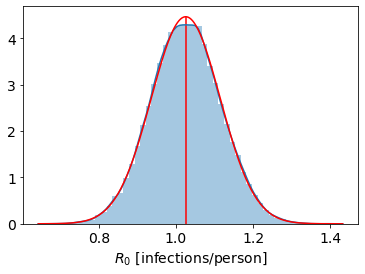

In [14]:
smp = samples['R0']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'$R_0$ [infections/person]')

# Typical time to removal for South Africa

Text(0.5, 0, 'Typical time to removal [days]')

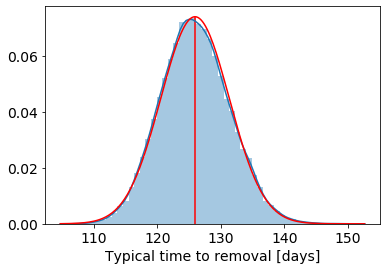

In [15]:
smp = samples['Tr']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Typical time to removal [days]')

# Predictions

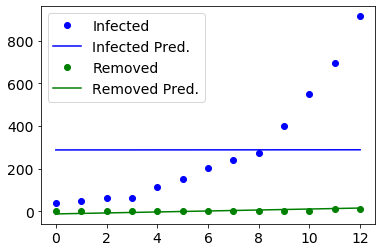

In [17]:
Ii = np.mean(samples['Ii'])
Ri = np.mean(samples['Ri'])
R0 = np.mean(samples['R0'])
Tr = np.mean(samples['Tr'])
beta = R0/Tr
gamma = 1.0/Tr
days = len(cases)
sir = SIR.SIR(N_pop, Ii, Ri, beta, gamma, days)
t = np.arange(days)
plt.plot(cases-recoveries-deaths, 'bo', label='Infected')
plt.plot(t, sir[:,1], 'b', label='Infected Pred.')
plt.plot(recoveries+deaths, 'go', label='Removed')
plt.plot(t, sir[:,2], 'g', label='Removed Pred.')
plt.legend()

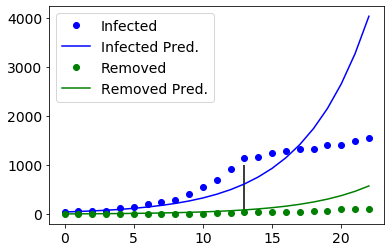

In [34]:
Ii = np.mean(samples['Ii'])
Ri = np.mean(samples['Ri'])
R0 = np.mean(samples['R0'])
Tr = np.mean(samples['Tr'])

Ii = 40.0
Ri = 0.0
R0 = 8.0
Tr = 30.0

beta = R0/Tr
gamma = 1.0/Tr
days = len(cases)
sir = SIR.SIR(N_pop, Ii, Ri, beta, gamma, days)
t = np.arange(days)
plt.plot(cases-recoveries-deaths, 'bo', label='Infected')
plt.plot(t, sir[:,1], 'b', label='Infected Pred.')
plt.plot(recoveries+deaths, 'go', label='Removed')
plt.plot(t, sir[:,2], 'g', label='Removed Pred.')
plt.legend()
plt.vlines(13, 0, 1000)
# plt.xlim(0, 5)
# plt.ylim(0, 100)